In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import functools
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import Dataset, random_split
from torchvision import transforms
import visdom
from torch.nn import init as init
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy.io
import math

In [2]:
device2 = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
num_step = 20 # five years
num_window = 4
num_predict_window = 16
img_n = 16
img_h = 8

In [7]:
class CustomDataset_plus(Dataset):
    def __init__(self, label_dir):
        self.label_dir = os.path.join(label_dir, "S")
        self.refine_well_dir = os.path.join(label_dir, "Well")
        self.K_dir = os.path.join(label_dir, "K")
        self.Pore_dir = os.path.join(label_dir, "Pore")
        self.Pressure_dir = os.path.join(label_dir, "Pressure")
        

        self.refine_file_list = os.listdir(self.refine_well_dir)
        self.K_file_list = os.listdir(self.K_dir)
        self.Pore_file_list = os.listdir(self.Pore_dir)
        self.Pressure_file_list = os.listdir(self.Pressure_dir)
        
        self.label_file_list = os.listdir(self.label_dir )
        

    def __len__(self):
        return len(self.label_file_list)

    def __getitem__(self, index):
        file_index = index
        rotation_index = index
        refine_file_name = self.refine_file_list[file_index]
        K_file_name = self.K_file_list[file_index]
        
        Pore_file_name = self.Pore_file_list[file_index]
        Pressure_file_name = self.Pressure_file_list[file_index]
        
        label_file_name = self.label_file_list[file_index]
        
        refine_file_path = os.path.join(self.refine_well_dir, refine_file_name)
        K_file_path = os.path.join(self.K_dir, K_file_name)
        Pore_file_path = os.path.join(self.Pore_dir, Pore_file_name)
        Pressure_file_path = os.path.join(self.Pressure_dir, Pressure_file_name)
        
        label_file_path = os.path.join(self.label_dir, label_file_name)
        
        K_data = scipy.io.loadmat(K_file_path)
        K_array = (np.log(K_data['K']))
        K_tensor = torch.from_numpy(K_array).reshape(1,img_n,img_n,img_h).to(device2).float()
        
        Pore_data = scipy.io.loadmat(Pore_file_path)
        Pore_array = Pore_data['p']
        Pore_tensor = torch.from_numpy(Pore_array).reshape(1,img_n,img_n,img_h).to(device2).float()
        
        Pressure_data = scipy.io.loadmat(Pressure_file_path)
        Pressure_array = (Pressure_data['pressure'])
        Pressure_tensor = torch.from_numpy(Pressure_array.transpose(3,0,1,2))[:num_step].to(device2).float()* 1e-7  / 2. 
        Pressure_tensor = torch.rot90(Pressure_tensor, k=rotation_index, dims=(1, 2))
      
        
        # Label file for reading label data
        label_data = scipy.io.loadmat(label_file_path)
        # Extract the array to be converted
        label_array = label_data['Ssmatrix']
        
        #Get the well location of the refine [16, 16, 8]
        label_refine_well = torch.from_numpy(scipy.io.loadmat(refine_file_path)["wc_globale_refine"]).to(device2).float() #用于loss使用
        
        input_refine_well = label_refine_well.reshape(1,img_n,img_n,img_h).to(device2).float()
        
         # Conditions to be added
        intermediate_condition = torch.cat([F.normalize(K_tensor,dim=0),F.normalize(Pore_tensor,dim=0),input_refine_well],axis=0)
        intermediate_condition = torch.rot90(intermediate_condition, k=rotation_index, dims=(1, 2))
        
        # Convert NumPy arrays to PyTorch 
        label_tensor = torch.from_numpy(label_array.transpose(3,4,0,1,2))[:,:num_step].to(device2)
        label_tensor = torch.rot90(label_tensor, k=rotation_index, dims=(2, 3))
        return  (label_tensor).float(),(intermediate_condition).float(),Pressure_tensor.float()

# Create customized dataset instances
label_dir = './CO2Datasets/refine/' 
dataset = CustomDataset_plus(label_dir)


_, valid_dataset = random_split(dataset, [0, 1])

# Use the data loader to load the training and validation sets
batch_size = 1
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [8]:
def default_init_weights(module_list, scale=1, bias_fill=0, **kwargs):
    """Initialize network weights.

    Args:
        module_list (list[nn.Module] | nn.Module): Modules to be initialized.
        scale (float): Scale initialized weights, especially for residual
            blocks. Default: 1.
        bias_fill (float): The value to fill bias. Default: 0
        kwargs (dict): Other arguments for initialization function.
    """
    if not isinstance(module_list, list):
        module_list = [module_list]
    for module in module_list:
        for m in module.modules():
            if isinstance(m, nn.Conv3d):
                init.kaiming_normal_(m.weight, **kwargs)
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, **kwargs)
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
            elif isinstance(m, _BatchNorm):
                init.constant_(m.weight, 1)
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)

In [9]:
#DoubleConv-does not change channel by default, residual-controls whether or not to utilize residual network
class DoubleConv(nn.Module):
    def __init__(self,in_c,out_c,mid_c=None,residual=False):
        super().__init__()
        self.residual = residual
        
        if not mid_c:
            mid_c = out_c
            
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_c,mid_c,kernel_size=3,padding=1),
            nn.GroupNorm(1,mid_c),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_c,out_c,kernel_size=3,padding=1),
            nn.GroupNorm(1,out_c)
        )
        self.relu = nn.ReLU(inplace=True)
    def forward(self,x):
        if self.residual:
            return self.relu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
        nn.MaxPool3d(2),
        DoubleConv(in_channels , in_channels, residual=True),
        DoubleConv(in_channels, out_channels),
        )
        
        
    def forward(self,x):
        x = self.maxpool_conv(x)
        return x


class Up(nn.Module):
    def __init__ (self,in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels,residual=True),
            DoubleConv(in_channels, out_channels,in_channels//2),
        )
        
    def forward(self,x, skip_x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = torch.cat([skip_x,x],dim=1)
        x= self.conv(x)
        return x

In [10]:
class UNet(nn.Module):
    def __init__(self,c_in=8+4+3,c_out_s=2*num_predict_window,c_out_p = num_predict_window):
        super().__init__()
        
        self.inc = DoubleConv(c_in,8)
        self.down1 = Down(8,16)
        self.down2 = Down(16,32)
        self.down3 = Down(32,64)
        
        self.bot1 = DoubleConv(64,128)
        self.bot2 = DoubleConv(128,128)
        self.bot3 = DoubleConv(128,64)
        
        self.up1 = Up(64+32,32)
        self.up2 = Up(32+16,16)
        
        self.up3_s = Up(16+8,16)
        self.up3_p = Up(16+8,8)
        
        self.out_s = nn.Conv3d(16,c_out_s,kernel_size=1,stride=1,padding=0)
        self.out_p = nn.Conv3d(8,c_out_p,kernel_size=1,stride=1,padding=0)
    def forward(self,x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        x = self.up1(x4,x3)
        x = self.up2(x,x2)
        x_s = self.up3_s(x,x1)
        x_p = self.up3_p(x,x1)
        x_s = self.out_s(x_s)
        x_p = self.out_p(x_p)
        return torch.cat([x_s,x_p],dim=1) 

In [13]:
def MRE(matrix1,matrix2):    
    # Calculate the absolute value difference and obtain the relative error 
    # (use the absolute value error for points where the true value is 0)
    diff = torch.abs(matrix1 - matrix2)
    relative_error = diff / (torch.abs(matrix1) + 1e-8)

    # Replace the relative error for points with a true value of 0 with the absolute value error
    mask_zero = (matrix1 == 0)
    relative_error[mask_zero] = diff[mask_zero]

    return relative_error

In [23]:
def GetOutputs(model):
    # Generate all predictions at once, since the number of prediction steps is 16
    model.eval()
    num_iters = (num_step-num_window)/num_predict_window
    #num_iters is 1
    step = [np.ones((img_n,img_n,img_h)) * i for i in range(num_step-num_predict_window)]
    targets ,intermidates,Pressure= batch[0].to(device2), batch[1].to(device2),batch[2].to(device2)
    sequence_saturation = torch.zeros_like(targets)
    sequence_pressure = torch.zeros_like(Pressure)
    sequence_saturation[:,:,:num_window,:,:,:] = targets[:,:,:num_window,:,:,:]
    sequence_pressure[:,:num_window,:,:,:] = Pressure[:,:num_window,:,:,:]
    for s in range(int(num_iters)):
        begin = s*num_predict_window
        tar_saturation = targets[:,:,(num_window+begin):(num_predict_window+num_window+begin),:,:,:].reshape(-1,2*num_predict_window,img_n,img_n,img_h)
        tar_pressure = Pressure[:,(num_window+begin):(num_predict_window+num_window+begin),:,:,:].reshape(-1,num_predict_window,img_n,img_n,img_h)
        tar = torch.cat([tar_saturation,tar_pressure],dim=1)
        saturation = sequence_saturation[:,:,begin:(num_window+begin),:,:,:].reshape(-1,2*num_window,img_n,img_n,img_h)
        pressure = sequence_pressure[:,begin:(num_window+begin),:,:,:].reshape(-1,num_window,img_n,img_n,img_h)
        inputs = torch.cat([saturation,pressure,intermidates],dim=1)
        outputs = model(inputs)
        output_saturation = outputs[:,:2*num_predict_window,:,:,:].detach()
        output_pressure = outputs[:,2*num_predict_window:,:,:,:].detach()
        output_saturation[output_saturation <= 0.02] = 0
        output_saturation[output_saturation >= 0.99] = 1
        targets[targets <= 0.02] = 0
        targets[targets >= 0.99] = 1
        sequence_saturation[:,:,(num_window+begin):(num_predict_window+num_window+begin),:,:,:] = output_saturation.reshape(-1,2,num_predict_window,img_n,img_n,img_h)
        sequence_pressure[:,(num_window+begin):(num_predict_window+num_window+begin),:,:,:] = output_pressure
    return sequence_saturation,sequence_pressure*2./1e-7,targets,Pressure*2./1e-7

In [24]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
def show_result_s(b,step,layer,outputs_s,outputs_p,targets,pressure,l1loss):   
    
    # Calculate relative error
    relative_error = MRE(targets[0, : , : , : , : ,:],outputs_s[0, : , : , : , : ,:])
    # Get the slice to display
    outputs_show = outputs_s[0, 1,step, :, :,layer].detach().cpu().numpy()
    targets_show = targets[0, 1,step, :, :,layer].detach().cpu().numpy()
    relative_error_show = relative_error[1,step, :, :,layer].detach().cpu().numpy()
    # Calculate MAE and MRE for every step
    if step<0:
        mae = []
        mre = []
        for i in range(num_step):
            mae.append(loss_fn(outputs_s[0, :,i, :, :,:],targets[0, :,i, :, :,:]).item())
            mre.append(torch.mean(relative_error[:,i, :, :,:]).item())
        result = np.round(np.array(mae), decimals=4)
        print("MAE\n")
        print(result,result.mean(),result[7],result[11],result[15],result[-1],torch.abs(outputs_s - targets).min(),torch.abs(outputs_s - targets).max())
        print("MRE\n")
        res = np.round(np.array(mre), decimals=4)
        print(res,res.mean(),res[7],res[11],res[15],res[-1],relative_error[:,i, :, :,:].min(),relative_error[:,i, :, :,:].max())
        l1loss.append(result[4:].mean()) 
    fig, axs = plt.subplots(1, 4, figsize=(16, 14))

    cmap = plt.cm.get_cmap('rainbow')
    cmap_colors = cmap(np.arange(cmap.N))
    cmap_colors[0] = [1.0, 1.0, 1.0, 1.0] 
    new_cmap = colors.ListedColormap(cmap_colors)
    

    #display the results simulated by traditional methods
    im0 = axs[0].imshow(targets_show, cmap=new_cmap,vmin=0, vmax=1)
    cbar0 = plt.colorbar(im0, ax=axs[0], shrink=0.2) 
    axs[0].tick_params(axis='both', which='both', labelsize=6)
    cbar0.ax.tick_params(labelsize=20)
    #display the results predicted by the model
    im2 = axs[1].imshow(outputs_show, cmap=new_cmap,vmin=0, vmax=1)
    cbar1 = plt.colorbar(im2, ax=axs[1],shrink=0.2) 
    axs[1].tick_params(axis='both', which='both', labelsize=6)
    cbar1.ax.tick_params(labelsize=20)
    #display absoluted error
    im3 = axs[2].imshow(np.abs(targets_show - outputs_show), cmap=new_cmap,vmin=0, vmax=0.2)
    cbar2 = plt.colorbar(im3, ax=axs[2],shrink=0.2)
    axs[2].tick_params(axis='both', which='both', labelsize=6)
    cbar2.ax.tick_params(labelsize=20)
    #display relative error
    im4 = axs[3].imshow(relative_error_show, cmap=new_cmap,vmin=0, vmax=1)
    cbar3 = plt.colorbar(im4, ax=axs[3],shrink=0.2)
    axs[3].tick_params(axis='both', which='both', labelsize=6)
    cbar3.ax.tick_params(labelsize=20)
    plt.tight_layout()
    show3d_result_s(model,step,outputs_s,targets,relative_error)
    plt.show()

In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
#Same as the code above that shows the saturation
def show_result_p(b,step,layer,outputs_s,outputs_p,targets,pressure,l1loss):
    relative_error = MRE(pressure[0 , : , : , : ,:],outputs_p[0 , : , : , : ,:])
    outputs_show = outputs_p[0,step, :, :,layer].detach().cpu().numpy()
    targets_show = pressure[0,step, :, :,layer].detach().cpu().numpy()
    relative_error_show = relative_error[step, :, :,layer].detach().cpu().numpy()
    if step<0:
        mae = []
        mre = []
        for i in range(num_step):
            mae.append(loss_fn(outputs_p[0,i, :, :,:],pressure[0,i, :, :,:]).item())
            mre.append(torch.mean(relative_error[i, :, :,:]).item())
        result = np.round(np.array(mae), decimals=4)
        print("MAE\n")
        print(result,result.mean(),result[7],result[11],result[15],result[-1],torch.abs(outputs_s - targets).min(),torch.abs(outputs_s - targets).max())
        print("MRE\n")
        res = np.round(np.array(mre), decimals=4)
        print(res,res.mean(),res[7],res[11],res[15],res[-1],relative_error[i, :, :,:].min(),relative_error[i, :, :,:].max())
        l1loss.append(result[4:].mean()) 
    fig, axs = plt.subplots(1, 4, figsize=(16, 14))
    cmap = plt.cm.get_cmap('rainbow')
    cmap_colors = cmap(np.arange(cmap.N))
    cmap_colors[0] = [1.0, 1.0, 1.0, 1.0] 
    new_cmap = colors.ListedColormap(cmap_colors)
    

    
    im0 = axs[0].imshow(targets_show, cmap=new_cmap)
    cbar0 = plt.colorbar(im0, ax=axs[0], shrink=0.18)
    axs[0].tick_params(axis='both', which='both', labelsize=6)
    cbar0.ax.tick_params(labelsize=20)

    
    im2 = axs[1].imshow(outputs_show, cmap=new_cmap)
    cbar1 = plt.colorbar(im2, ax=axs[1],shrink=0.18) 
    axs[1].tick_params(axis='both', which='both', labelsize=6)
    cbar1.ax.tick_params(labelsize=20)
    
    im3 = axs[2].imshow(np.abs(targets_show - outputs_show), cmap=new_cmap)
    cbar2 = plt.colorbar(im3, ax=axs[2],shrink=0.18) 
    axs[2].tick_params(axis='both', which='both', labelsize=6)
    cbar2.ax.tick_params(labelsize=20)
    
    im4 = axs[3].imshow(relative_error_show, cmap=new_cmap)
    cbar3 = plt.colorbar(im4, ax=axs[3],shrink=0.18)
    axs[3].tick_params(axis='both', which='both', labelsize=6)
    cbar3.ax.tick_params(labelsize=20)
    plt.tight_layout()
    plt.show()


In [26]:
import matplotlib.cm as cm
#Demonstrate 3-D saturation
def show3d_result_s(model_pre,step,outputs,targets,relative_error):
    outputs_show = np.flip(outputs[0,1,step, :, :,:].detach().cpu().numpy(), axis=-1)
    targets_show = np.flip(targets[0, 1,step, :, :,:].detach().cpu().numpy(), axis=-1)
    relative_error_show = np.flip(relative_error[1,step, :, :,:].detach().cpu().numpy(), axis=-1)

    # Colorize the data using the rainbow color mapper
    colors1 = cm.rainbow(targets_show)
    colors2 = cm.rainbow(outputs_show)
    error = np.abs(targets_show - outputs_show)
    colors3 = cm.rainbow(error)
    colors4 = cm.rainbow(relative_error_show)
    fig = plt.figure(figsize=(13, 12))

    ax1 = fig.add_subplot(141, projection='3d')
    ax1.voxels(targets_show, facecolors=colors1, linewidth=0.1)
    ax1.set_aspect('auto')
    cbar1 = fig.colorbar(cm.ScalarMappable(cmap=cm.rainbow), ax=ax1, shrink=0.12)
    cbar1.ax.tick_params(labelsize=10)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax2 = fig.add_subplot(142, projection='3d')
    ax2.voxels(outputs_show, facecolors=colors2, linewidth=0.1)
    ax2.set_aspect('auto')
    cbar2 = fig.colorbar(cm.ScalarMappable(cmap=cm.rainbow), ax=ax2, shrink=0.12)
    cbar2.ax.tick_params(labelsize=10)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax3 = fig.add_subplot(143, projection='3d')
    ax3.voxels(np.abs(targets_show-outputs_show), facecolors=colors3, linewidth=0.1)
    ax3.set_aspect('auto')
    cbar3 = fig.colorbar(cm.ScalarMappable(cmap=cm.rainbow), ax=ax3, shrink=0.12)
    cbar3.ax.tick_params(labelsize=10)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_zticks([])
    
    ax4 = fig.add_subplot(144, projection='3d')
    ax4.voxels(relative_error_show, facecolors=colors4, linewidth=0.1)
    ax4.set_aspect('auto')
    cbar4 = fig.colorbar(cm.ScalarMappable(cmap=cm.rainbow), ax=ax4, shrink=0.12)
    cbar4.ax.tick_params(labelsize=10)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_zticks([])
    plt.tight_layout()
    plt.show()

In [27]:
import matplotlib.cm as cm
# Showing pressure in three dimensions
def show3d_result_p(model_pre,step,outputs,targets,relative_error):
    outputs_show = np.flip(outputs[0,step, :, :,:].detach().cpu().numpy(), axis=-1)
    targets_show = np.flip(targets[0,step, :, :,:].detach().cpu().numpy(), axis=-1)
    relative_error_show = np.flip(relative_error[step, :, :,:].detach().cpu().numpy(), axis=-1)

    colors1 = cm.rainbow(targets_show)
    colors2 = cm.rainbow(outputs_show)
    error = np.abs(targets_show - outputs_show)
    colors3 = cm.rainbow(error)
    colors4 = cm.rainbow(relative_error_show)
    fig = plt.figure(figsize=(13, 12))

    ax1 = fig.add_subplot(141, projection='3d')
    ax1.voxels(targets_show, facecolors=colors1, linewidth=0.1)
    ax1.set_aspect('auto')
    cbar1 = fig.colorbar(cm.ScalarMappable(cmap=cm.rainbow), ax=ax1, shrink=0.12)
    cbar1.ax.tick_params(labelsize=10)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax2 = fig.add_subplot(142, projection='3d')
    ax2.voxels(outputs_show, facecolors=colors2, linewidth=0.1)
    ax2.set_aspect('auto')
    cbar2 = fig.colorbar(cm.ScalarMappable(cmap=cm.rainbow), ax=ax1, shrink=0.12)
    cbar2.ax.tick_params(labelsize=10)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax3 = fig.add_subplot(143, projection='3d')
    ax3.voxels(np.abs(targets_show-outputs_show), facecolors=colors3, linewidth=0.1)
    ax3.set_aspect('auto')
    cbar3 = fig.colorbar(cm.ScalarMappable(cmap=cm.rainbow), ax=ax3, shrink=0.12)
    cbar3.ax.tick_params(labelsize=10)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_zticks([])
    
    ax4 = fig.add_subplot(144, projection='3d')
    ax4.voxels(relative_error_show, facecolors=colors4, linewidth=0.1)
    ax4.set_aspect('auto')
    cbar4 = fig.colorbar(cm.ScalarMappable(cmap=cm.rainbow), ax=ax4)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_zticks([])
    plt.tight_layout()
    plt.show()

In [28]:
model = UNet().to(device2)
from torch.nn import DataParallel
# Parallelize the model with DataParallel
model = nn.DataParallel(model, device_ids=[0])
loss_fn = nn.L1Loss()

In [29]:
# Load pre-trained model parameters
pretrained_dict = torch.load('./model4P16/UNet.pth',map_location=torch.device('cuda:0')) #pth file path
model_dict = model.state_dict()
# Check and update model parameters
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [30]:
it= iter(valid_loader)

0——————————————————————————


C:\Users\13552\AppData\Local\Temp\ipykernel_14316\152578252.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow')


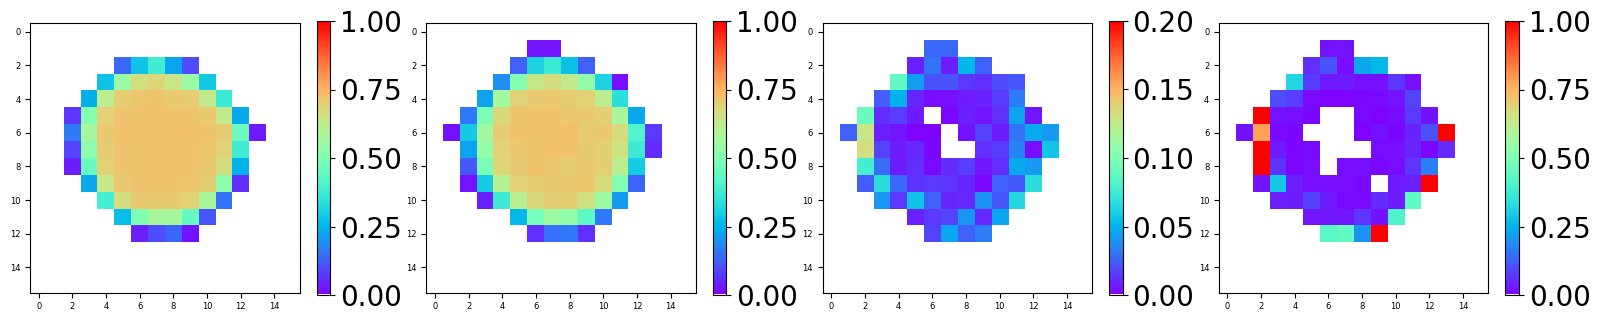

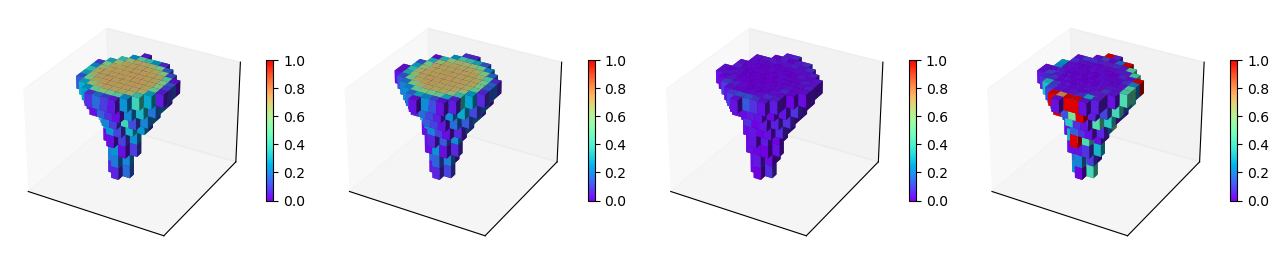

MAE

[0.0001 0.0001 0.0001 0.0001 0.0044 0.0029 0.0032 0.0035 0.0035 0.0033
 0.0035 0.0036 0.0039 0.0042 0.0046 0.0048 0.0055 0.0062 0.0069 0.0077] 0.0036049999999999997 0.0035 0.0036 0.0048 0.0077 tensor(0., device='cuda:0') tensor(0.2897, device='cuda:0')
MRE

[0.0001 0.0001 0.0001 0.0001 0.0171 0.0095 0.0104 0.0115 0.0127 0.0128
 0.0135 0.0129 0.0137 0.0147 0.0163 0.0179 0.0179 0.0206 0.0222 0.0234] 0.012375 0.0115 0.0129 0.0179 0.0234 tensor(0., device='cuda:0') tensor(2.4942, device='cuda:0')


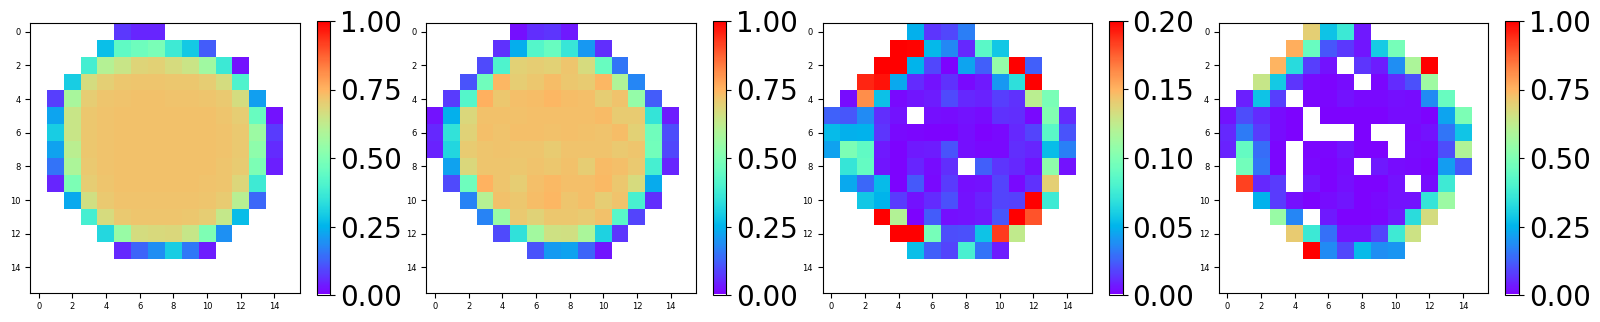

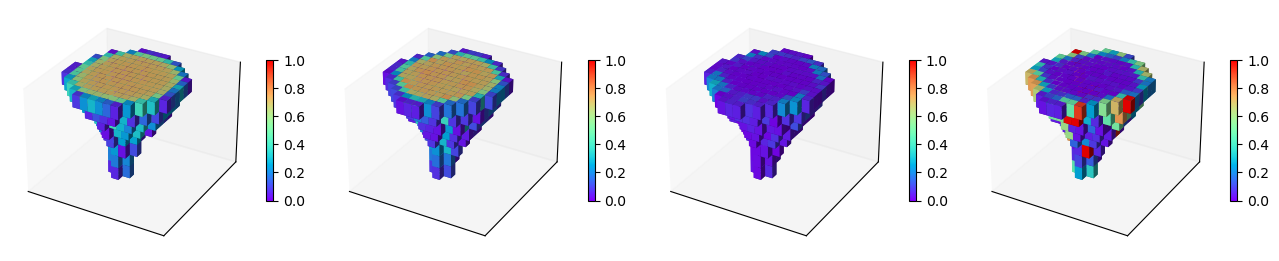

C:\Users\13552\AppData\Local\Temp\ipykernel_14316\2850132912.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('rainbow')


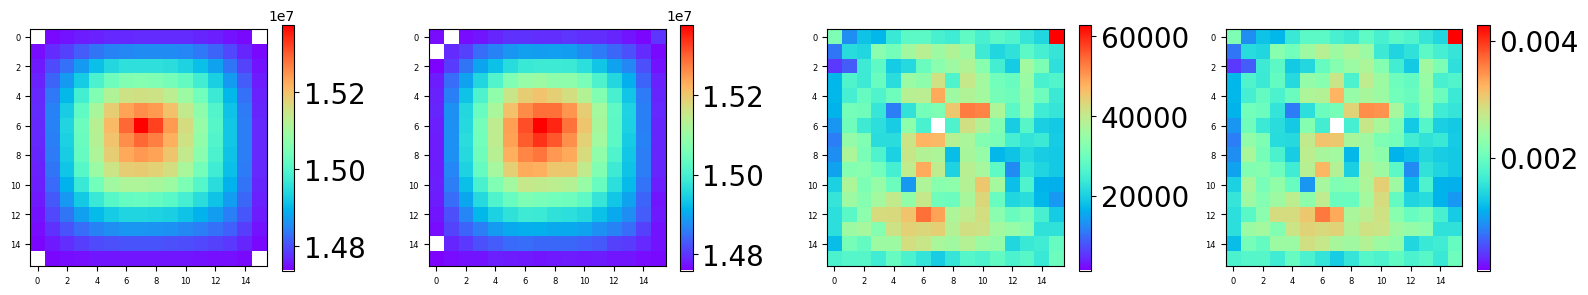

MAE

[    0.         0.         0.         0.     22211.9492 31022.1777
 18232.1504 21929.0098 13482.2949 21424.2305 15126.5605 14562.5742
 21130.1582 17638.3965 14384.252  22012.916  16565.0469 28092.8789
 17665.5723 20280.9492] 15788.055859999999 21929.0098 14562.5742 22012.916 20280.9492 tensor(0., device='cuda:0') tensor(0.2897, device='cuda:0')
MRE

[0.     0.     0.     0.     0.0014 0.002  0.0012 0.0014 0.0009 0.0014
 0.001  0.001  0.0014 0.0012 0.0009 0.0014 0.0011 0.0019 0.0012 0.0013] 0.001035 0.0014 0.001 0.0014 0.0013 tensor(4.6302e-07, device='cuda:0') tensor(0.0066, device='cuda:0')


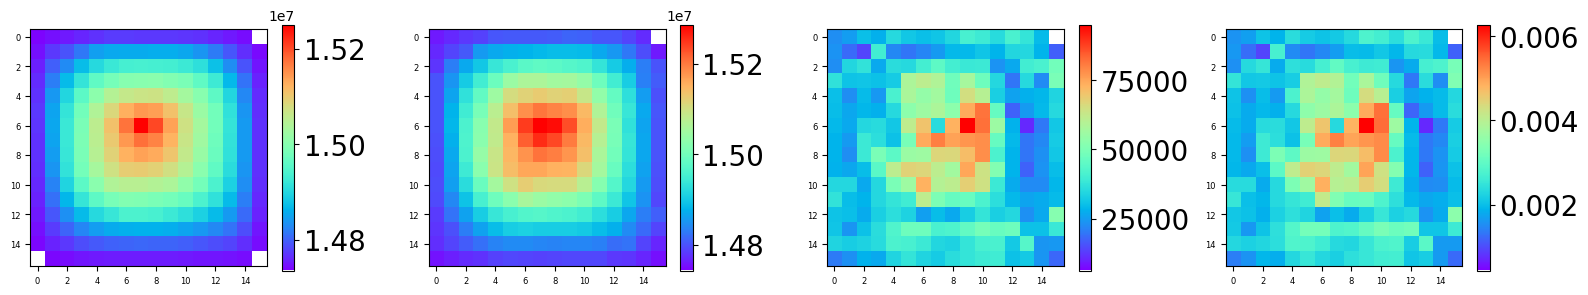

In [31]:
for i in range(len(valid_loader)):
    batch = next(it)
    print(str(i)+"——————————————————————————")
    outputs_s,outputs_p,targets,pressure = GetOutputs(model)
    #The second parameter is the number of steps to be displayed.
    show_result_s(i,9,0,outputs_s,outputs_p,targets,pressure,[])
    show_result_s(i,-1,0,outputs_s,outputs_p,targets,pressure,[])
    show_result_p(i,9,0,outputs_s,outputs_p,targets,pressure,[])
    show_result_p(i,-1,0,outputs_s,outputs_p,targets,pressure,[])
   